In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from tqdm import trange
import pandas as pd

In [2]:
sys.path.append('/home/raffaele/Documents/ml-project/src/')

In [3]:
from torch_utility import *

## Import Dataset

In [4]:
data = np.genfromtxt('/home/raffaele/Documents/ml-project/cup/ML-CUP20-TR.csv', delimiter=',', dtype=np.float32)
X = data[:, 1:-2]
y = data[:, -2:]

In [5]:
print(X.shape)
print(y.shape)

(1524, 10)
(1524, 2)


### Split train set and Validation Set

In [6]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(1219, 10)
(1219, 2)
(305, 10)
(305, 2)


In [8]:
Xtrain = Xtrain.astype('float32')
ytrain = ytrain.astype('float32')

Xval = Xval.astype('float32')
yval = yval.astype('float32')

## Define Models

In [9]:
class Net(nn.Module):

    def __init__(self, num_units1, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(10,num_units1)
#         self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units1,2)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
#         x = self.activation(self.hidden1(x))
        x = self.output(x)
        return x

In [10]:
net = Net(50, torch.relu)
print(net)

Net(
  (input_layer): Linear(in_features=10, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=2, bias=True)
)


### Initialize the weights

In [11]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
        
net.apply(init_weights)

Net(
  (input_layer): Linear(in_features=10, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=2, bias=True)
)

In [12]:
# def MEE(y_real, y_pred): 
#     return torch.div(torch.sum(F.pairwise_distance(y_real, y_pred, p=2)), len(y_real))

In [13]:
class MEE(torch.nn.Module):

    def __init__(self):
        super(MEE, self).__init__()

    def forward(self, y_true, y_pred):
#         return torch.mean(torch.linalg.norm(y_pred - y_true))
#         return torch.mean(torch.cdist(y_true, y_pred, p=2))
        return torch.div(torch.sum(torch.pairwise_distance(y_true, y_pred)), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true, ord=None), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true), len(y_true))

In [14]:
from sklearn.metrics import euclidean_distances

def mean_euclidean_error(y_true, y_pred):
    assert y_true.shape == y_pred.shape
#     return np.mean(np.linalg.norm(y_pred - y_true))
#     return np.divide(np.linalg.norm(y - y_real), len(y_real))
#     return np.mean(euclidean_distances(y_true, y_pred))
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1)) #utilizzare questa loss la prossima grid

In [120]:
from skorch import NeuralNetRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping

Network = NeuralNetRegressor(net, verbose=0, callbacks=[EarlyStopping(patience=100)])

params = {
    'max_epochs':[1000],
    'module__activation':[torch.relu],
    'module__num_units1' :[50, 75, 100],
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [64],
    'criterion' : [MEE],
    'optimizer': [optim.SGD],
    'optimizer__weight_decay': [0.0001, 0.00001, 0.001, 0.00005],
    'optimizer__momentum': [0.7, 0.8, 0.9],
    'optimizer__nesterov':[True],
}

neg_mean_euclidean_error = make_scorer(mean_euclidean_error, greater_is_better=False)
# The grid search module is instantiated
gs = GridSearchCV(Network, params,
                  refit=False,
                  scoring=neg_mean_euclidean_error,
                  cv=3,
                  return_train_score=True,
                  n_jobs=3,
                  verbose=2)
# Initialize grid search
gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Net(
    (input_layer): Linear(in_features=10, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=2, bias=True)
  ),
),
             n_jobs=3,
             param_grid={'batch_size': [64],
                         'criterion': [<class '__main__.MEE'>],
                         'lr': [0.01, 0.006, 0.03], 'max_epochs': [1000],
                         'module__ac...
                                                <built-in method sigmoid of type object at 0x7fd97539d780>],
                         'module__num_units1': [50, 75, 100],
                         'optimizer': [<class 'torch.optim.sgd.SGD'>],
                         'optimizer__momentum': [0.7, 0.8, 0.9],
                         'optimizer__nesterov': [True],
                         'optimizer__weight_decay': [0.0001, 1e-05, 0.0003,
                                                     0.

In [122]:
df = pd.DataFrame(gs.cv_results_)[['param_module__num_units1',
#                                    'param_module__num_units2',
                                   'param_batch_size',
                                   'param_module__activation',
                                   'param_lr', 
                                     'param_max_epochs', 'param_optimizer','param_optimizer__weight_decay',
                                   'param_optimizer__momentum', 
                                   'param_optimizer__nesterov',
                                     'mean_train_score', 'mean_test_score', 
                                   'std_train_score','mean_fit_time','std_fit_time',
                                     'rank_test_score']].sort_values(by='rank_test_score')
df.rename(columns={'param_module__num_units1': '#Units1',
#                    'param_module__num_units2': '#Units2',
                   'param_max_epochs': 'max_epochs',
                   'param_lr': 'lr',
                   'param_module__activation': 'activation',
                   'param_batch_size': 'batch_size',
                   'param_optimizer': 'optimizer',
                   'param_optimizer__momentum': 'momentum',
                   'param_optimizer__nesterov':'nesterov',
                   'param_optimizer__weight_decay': 'weight_decay',
                   'std_train_score' : 'std_train_score',
                   'mean_test_score': 'mean_val_score',
                   'rank_test_score': 'rank_val_score'}, inplace=True)
df.mean_train_score *= -1
df.mean_val_score *= -1

def highlight_equal(s, value, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == value
    return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

df.head(30).style.apply(highlight_equal, value=1, 
                        column=['rank_val_score'], axis=1).hide_index()

#Units1,batch_size,activation,lr,max_epochs,optimizer,weight_decay,momentum,nesterov,mean_train_score,mean_val_score,std_train_score,mean_fit_time,std_fit_time,rank_val_score
50,64,,0.006000,1000,,0.000600,0.900000,True,2.518564,2.897166,0.051413,55.525440,14.454862,1
75,64,,0.010000,1000,,0.000100,0.800000,True,2.552109,2.906147,0.059615,54.738617,9.972375,2
75,64,,0.010000,1000,,0.000300,0.800000,True,2.577484,2.909380,0.055410,50.804795,16.248909,3
50,64,,0.010000,1000,,0.000300,0.900000,True,2.475767,2.910451,0.057379,27.281302,12.196977,4
50,64,,0.006000,1000,,0.000300,0.900000,True,2.503532,2.910924,0.096406,48.003039,15.463717,5
75,64,,0.006000,1000,,0.000010,0.900000,True,2.546872,2.913977,0.122980,40.034772,19.720087,6
100,64,,0.010000,1000,,0.000100,0.800000,True,2.558659,2.916010,0.057457,52.571050,16.053093,7
100,64,,0.006000,1000,,0.000100,0.900000,True,2.515997,2.917110,0.074223,50.140725,10.168286,8
50,64,,0.006000,1000,,0.000010,0.900000,True,2.526639,2.921485,0.057292,37.110491,10.528239,9
100,64,,0.010000,1000,,0.000010,0.900000,True,2.445141,2.921801,0.073664,28.450599,8.022683,10


In [123]:
df.to_csv('../../grid_results/gridSearch_prova.csv', index=False)

In [124]:
gs.param_grid

{'max_epochs': [1000],
 'module__activation': [<function _VariableFunctionsClass.relu>,
  <function _VariableFunctionsClass.tanh>,
  <function _VariableFunctionsClass.sigmoid>],
 'module__num_units1': [50, 75, 100],
 'lr': [0.01, 0.006, 0.03],
 'batch_size': [64],
 'criterion': [__main__.MEE],
 'optimizer': [torch.optim.sgd.SGD],
 'optimizer__weight_decay': [0.0001, 1e-05, 0.0003, 0.0006],
 'optimizer__momentum': [0.7, 0.8, 0.9],
 'optimizer__nesterov': [True]}

In [154]:
Network.get_params().keys()

dict_keys(['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 'iterator_valid', 'dataset', 'train_split', 'callbacks', 'predict_nonlinearity', 'warm_start', 'verbose', 'device', 'callbacks__epoch_timer', 'callbacks__train_loss', 'callbacks__train_loss__name', 'callbacks__train_loss__lower_is_better', 'callbacks__train_loss__on_train', 'callbacks__valid_loss', 'callbacks__valid_loss__name', 'callbacks__valid_loss__lower_is_better', 'callbacks__valid_loss__on_train', 'callbacks__print_log', 'callbacks__print_log__keys_ignored', 'callbacks__print_log__sink', 'callbacks__print_log__tablefmt', 'callbacks__print_log__floatfmt', 'callbacks__print_log__stralign'])

In [155]:
print(gs.best_params_)

{'batch_size': 64, 'criterion': <class '__main__.MEE'>, 'lr': 0.001, 'max_epochs': 300, 'module__num_units1': 50, 'module__num_units2': 30, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.8, 'optimizer__weight_decay': 0.0001}


In [156]:
gs.best_score_

-3.2546486854553223

In [104]:
from skorch import NeuralNetRegressor
test_net = Net(100, 50, torch.relu)
nett = NeuralNetRegressor(test_net, max_epochs=1000,
                          lr=0.06,
                          batch_size=32,
                          optimizer=optim.SGD,
                          optimizer__momentum=0.8,
                          optimizer__weight_decay=0.00001,
                          optimizer__nesterov = True,
                          criterion=torch.nn.MSELoss)
# Training
nett.fit(Xtrain, ytrain)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x50 and 100x2)

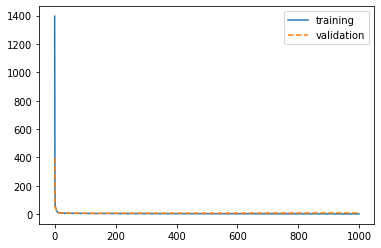

In [183]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.legend()
plt.show()

In [184]:
prova = nett.predict(Xval)

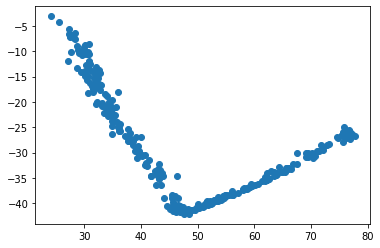

In [185]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

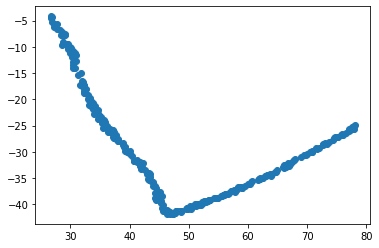

In [186]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [187]:
mean_euclidean_error(prova, yval)

3.4315946

In [225]:
class Net(nn.Module):

    def __init__(self, num_units1, num_units2, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(10,num_units1)
        self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units2,2)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        x = self.activation(self.hidden1(x))
        x = self.output(x)
        return x

In [226]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

total = []
for i in range(0,10):
    test_net = Net(100, 50, torch.sigmoid)
    nett = NeuralNetRegressor(test_net, max_epochs=1000,
                              lr=0.006,
                              batch_size=64,
                              optimizer=optim.SGD,
                              optimizer__momentum=0.8,
                              optimizer__weight_decay=0.0001,
                              optimizer__nesterov = True,
                              criterion=MEE,
    #                           callbacks=[EarlyStopping(patience=100)]
                             )
    # Training
    nett.fit(Xtrain, ytrain)

    prova = nett.predict(Xval)
    ris = mean_euclidean_error(prova, yval)
    total.append(ris)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       55.2206       49.9313  0.0659
      2       46.8752       38.2519  0.1068
      3       32.5899       22.8391  0.0523
      4       20.8719       17.5693  0.0498
      5       17.3972       16.2651  0.0500
      6       16.3121       15.8018  0.0540
      7       15.6812       15.2168  0.0591
      8       14.9103       14.2842  0.0699
      9       13.8012       12.9484  0.0615
     10       12.3312       11.3949  0.0562
     11       10.7552       10.0231  0.0510
     12        9.5555        9.1342  0.0503
     13        8.9709        8.7358  0.0508
     14        8.7624        8.6011  0.0557
     15        8.6883        8.5361  0.0546
     16        8.6506        8.4941  0.0528
     17        8.6235        8.4598  0.0515
     18        8.5988        8.4293  0.0506
     19        8.5758        8.4014  0.0575
     20        8.5540        8.3756  0.1015
     21        8.5331        8.3

    132        3.1702        3.2777  0.0933
    133        3.1664        3.2742  0.0493
    134        3.1627        3.2707  0.0426
    135        3.1592        3.2673  0.0555
    136        3.1556        3.2640  0.0527
    137        3.1521        3.2608  0.0925
    138        3.1487        3.2576  0.0588
    139        3.1453        3.2545  0.0528
    140        3.1420        3.2514  0.0591
    141        3.1387        3.2484  0.0478
    142        3.1355        3.2454  0.0520
    143        3.1323        3.2423  0.0445
    144        3.1292        3.2394  0.0446
    145        3.1261        3.2364  0.0510
    146        3.1230        3.2334  0.0481
    147        3.1200        3.2305  0.0582
    148        3.1170        3.2276  0.0475
    149        3.1140        3.2246  0.0427
    150        3.1111        3.2218  0.0432
    151        3.1082        3.2189  0.0754
    152        3.1053        3.2161  0.0847
    153        3.1024        3.2132  0.0513
    154        3.0996        3.2

    265        2.8484        2.9713  0.1646
    266        2.8469        2.9699  0.0513
    267        2.8453        2.9685  0.0518
    268        2.8437        2.9671  0.0586
    269        2.8422        2.9658  0.1520
    270        2.8407        2.9645  0.0917
    271        2.8392        2.9633  0.0650
    272        2.8377        2.9620  0.1110
    273        2.8362        2.9608  0.0407
    274        2.8347        2.9596  0.0856
    275        2.8332        2.9584  0.0409
    276        2.8318        2.9572  0.0474
    277        2.8303        2.9560  0.0862
    278        2.8289        2.9548  0.0610
    279        2.8274        2.9537  0.0628
    280        2.8260        2.9526  0.0474
    281        2.8246        2.9515  0.0468
    282        2.8232        2.9504  0.0774
    283        2.8217        2.9494  0.0522
    284        2.8203        2.9483  0.0425
    285        2.8189        2.9473  0.0811
    286        2.8175        2.9462  0.0446
    287        2.8161        2.9

    401        2.7014        2.8709  0.0396
    402        2.6985        2.8680  0.0446
    403        2.6999        2.8699  0.0409
    404        2.6972        2.8664  0.0802
    405        2.6985        2.8689  0.0376
    406        2.6954        2.8651  0.0389
    407        2.6971        2.8680  0.0473
    408        2.6938        2.8653  0.0463
    409        2.6955        2.8669  0.0391
    410        2.6931        2.8637  0.0373
    411        2.6940        2.8660  0.0402
    412        2.6910        2.8625  0.0382
    413        2.6938        2.8650  0.0394
    414        2.6889        2.8641  0.0389
    415        2.6887        2.8607  0.0737
    416        2.6907        2.8637  0.0488
    417        2.6869        2.8625  0.1481
    418        2.6874        2.8617  0.0519
    419        2.6859        2.8595  0.0503
    420        2.6887        2.8616  0.0443
    421        2.6838        2.8610  0.0509
    422        2.6837        2.8582  0.0551
    423        2.6853        2.8

      2       48.1544       40.0433  0.0599
      3       34.3534       23.9802  0.0407
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       55.2604       49.8472  0.0383
      2       46.7050       37.9785  0.0463
      3       32.2556       22.6304  0.0511
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       54.6634       49.2841  0.0367
      2       46.0376       37.1548  0.0466
      3       31.4002       21.9081  0.0423
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       55.5325       50.5104  0.0399
      2       47.8581       39.7639  0.0449
      3       34.2606       24.1835  0.0415
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       55.3850       50.0726  0.0368
      2       47.0885       38.6580  0.0462
      3       33.1192       23.3166  0.0443
  epoch    train_loss    valid_l

In [227]:
total

[3.0724862,
 7.8159347,
 21.600214,
 29.726019,
 21.269506,
 19.57548,
 17.090656,
 17.473583,
 17.803865,
 21.654264]

In [228]:
np.mean(total)

17.7082

In [229]:
np.std(total)

7.098052

In [230]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.ylim(2,10)
plt.xlim(0,1000)
plt.legend()
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [157]:
prova = nett.predict(Xval)

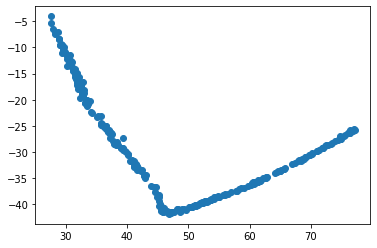

In [158]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

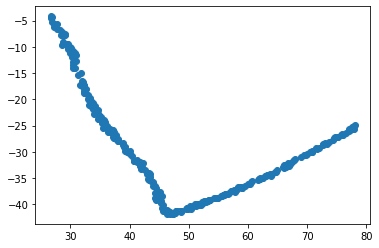

In [159]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [160]:
mean_euclidean_error(prova, yval)

3.0030868

In [122]:
class Net(nn.Module):

    def __init__(self, num_units1, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(10,num_units1)
#         self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units1,2)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
#         x = self.activation(self.hidden1(x))
        x = self.output(x)
        return x

In [123]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

test_net = Net(50, torch.relu)
test_net.apply(init_weights)
nett = NeuralNetRegressor(test_net, max_epochs=1000,
                          lr=0.001,
                          batch_size=64,
                          optimizer=optim.SGD,
                          optimizer__momentum=0.9,
                          optimizer__weight_decay=0.00001,
#                           optimizer__nesterov = True,
                          criterion=MEE,
                          callbacks=[EarlyStopping(patience=100)]
                         )
# Training
nett.fit(Xtrain, ytrain)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       57.0715       55.1146  0.0393
      2       56.2738       54.1226  0.0357
      3       55.1794       52.8938  0.0331
      4       53.8132       51.3211  0.0335
      5       52.0198       49.2049  0.0329
      6       49.5656       46.2668  0.0325
      7       46.1280       42.1298  0.0331
      8       41.2791       36.3403  0.0346
      9       34.6365       28.8604  0.0329
     10       26.7841       21.2759  0.0326
     11       18.5159       14.0154  0.0311
     12       14.1534       12.8515  0.0309
     13       13.0691       11.5614  0.0312
     14       11.9950       10.6172  0.0306
     15       11.1169        9.8318  0.0306
     16       10.3494        9.2694  0.0294
     17        9.7445        8.8992  0.0302
     18        9.2921        8.6357  0.0305
     19        8.9390        8.4131  0.0316
     20        8.6417        8.2229  0.0330
     21        8.3925        8.0

    132        3.9222        4.1499  0.0347
    133        3.9161        4.1442  0.0322
    134        3.9101        4.1384  0.0331
    135        3.9041        4.1330  0.0318
    136        3.8979        4.1278  0.0318
    137        3.8918        4.1226  0.0332
    138        3.8856        4.1175  0.0322
    139        3.8795        4.1125  0.0328
    140        3.8737        4.1077  0.0318
    141        3.8678        4.1030  0.0310
    142        3.8620        4.0978  0.0319
    143        3.8563        4.0925  0.0320
    144        3.8507        4.0872  0.0316
    145        3.8454        4.0820  0.0314
    146        3.8400        4.0776  0.0304
    147        3.8342        4.0723  0.0327
    148        3.8287        4.0674  0.0321
    149        3.8232        4.0623  0.0315
    150        3.8181        4.0572  0.0302
    151        3.8127        4.0519  0.0319
    152        3.8074        4.0468  0.0350
    153        3.8021        4.0423  0.0323
    154        3.7967        4.0

    265        3.2951        3.5406  0.0308
    266        3.2919        3.5385  0.0300
    267        3.2889        3.5363  0.0311
    268        3.2859        3.5339  0.0297
    269        3.2828        3.5316  0.0311
    270        3.2799        3.5293  0.0330
    271        3.2769        3.5269  0.0397
    272        3.2741        3.5249  0.0323
    273        3.2714        3.5229  0.0316
    274        3.2688        3.5208  0.0329
    275        3.2662        3.5186  0.0313
    276        3.2636        3.5169  0.0334
    277        3.2612        3.5153  0.0318
    278        3.2586        3.5133  0.0310
    279        3.2562        3.5111  0.0308
    280        3.2540        3.5091  0.0317
    281        3.2517        3.5074  0.0380
    282        3.2496        3.5056  0.0309
    283        3.2474        3.5039  0.0305
    284        3.2452        3.5019  0.0303
    285        3.2435        3.5003  0.0306
    286        3.2413        3.4972  0.0324
    287        3.2396        3.4

    409        3.0495        3.3698  0.0305
    410        3.0498        3.3725  0.0304
    411        3.0475        3.3676  0.0300
    412        3.0476        3.3717  0.0299
    413        3.0455        3.3665  0.0301
    414        3.0457        3.3696  0.0301
    415        3.0431        3.3632  0.0300
    416        3.0436        3.3684  0.0302
    417        3.0416        3.3635  0.0300
    418        3.0407        3.3652  0.0301
    419        3.0389        3.3603  0.0299
    420        3.0390        3.3642  0.0304
    421        3.0372        3.3597  0.0302
    422        3.0370        3.3614  0.0301
    423        3.0350        3.3571  0.0304
    424        3.0347        3.3599  0.0303
    425        3.0331        3.3569  0.0330
    426        3.0330        3.3575  0.0323
    427        3.0309        3.3535  0.0337
    428        3.0306        3.3563  0.0340
    429        3.0289        3.3515  0.0336
    430        3.0289        3.3547  0.0399
    431        3.0270        3.3

    563        2.9147        3.2374  0.0304
    564        2.9252        3.2456  0.0300
    565        2.9145        3.2363  0.0296
    566        2.9229        3.2433  0.0304
    567        2.9128        3.2361  0.0302
    568        2.9221        3.2441  0.0302
    569        2.9126        3.2353  0.0301
    570        2.9196        3.2417  0.0302
    571        2.9110        3.2344  0.0313
    572        2.9193        3.2419  0.0305
    573        2.9107        3.2336  0.0301
    574        2.9170        3.2395  0.0302
    575        2.9084        3.2316  0.0305
    576        2.9160        3.2404  0.0321
    577        2.9098        3.2314  0.0308
    578        2.9133        3.2368  0.0302
    579        2.9078        3.2307  0.0301
    580        2.9134        3.2369  0.0306
    581        2.9061        3.2285  0.0306
    582        2.9128        3.2343  0.0301
    583        2.9040        3.2269  0.0309
    584        2.9137        3.2337  0.0306
    585        2.9029        3.2

    724        2.8289        3.1770  0.0353
    725        2.8169        3.1711  0.0341
    726        2.8292        3.1828  0.0337
    727        2.8139        3.1765  0.0338
    728        2.8327        3.1895  0.0360
    729        2.8158        3.1677  0.0343
    730        2.8367        3.1843  0.0353
    731        2.8121        3.1658  0.0386
    732        2.8330        3.1836  0.0373
    733        2.8106        3.1731  0.0385
    734        2.8288        3.1900  0.0330
    735        2.8118        3.1666  0.0351
    736        2.8312        3.1823  0.0375
    737        2.8091        3.1643  0.0392
    738        2.8290        3.1807  0.0355
    739        2.8074        3.1709  0.0337
    740        2.8243        3.1893  0.0333
    741        2.8084        3.1651  0.0354
    742        2.8263        3.1811  0.0339
    743        2.8062        3.1628  0.0389
    744        2.8225        3.1778  0.0378
    745        2.8036        3.1724  0.0386
    746        2.8223        3.1

    896        2.7473        3.1386  0.0346
    897        2.7289        3.1258  0.0361
    898        2.7473        3.1480  0.0359
    899        2.7290        3.1238  0.0359
    900        2.7464        3.1436  0.0350
    901        2.7248        3.1296  0.0352
    902        2.7474        3.1479  0.0355
    903        2.7257        3.1189  0.0351
    904        2.7471        3.1472  0.0346
    905        2.7237        3.1210  0.0344
    906        2.7433        3.1459  0.0332
    907        2.7257        3.1218  0.0351
    908        2.7410        3.1414  0.0342
    909        2.7227        3.1267  0.0335
    910        2.7383        3.1405  0.0355
    911        2.7214        3.1275  0.0372
    912        2.7346        3.1366  0.0354
    913        2.7221        3.1327  0.0338
    914        2.7336        3.1379  0.0340
    915        2.7217        3.1306  0.0348
    916        2.7337        3.1344  0.0356
    917        2.7180        3.1324  0.0406
    918        2.7317        3.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (input_layer): Linear(in_features=10, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=2, bias=True)
  ),
)

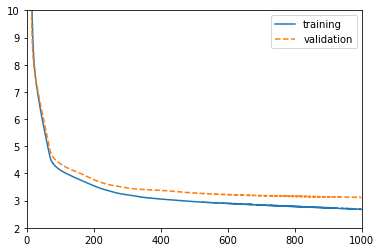

In [124]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.ylim(2,10)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [125]:
prova = nett.predict(Xval)

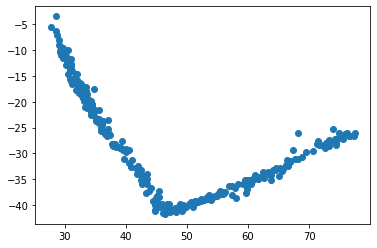

In [126]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

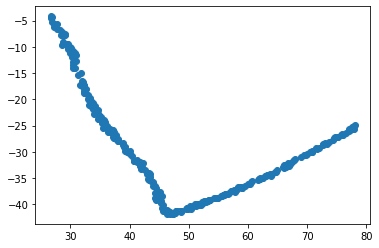

In [127]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [128]:
mean_euclidean_error(prova, yval)

3.286791